# TorchVision Object Detection Finetuning

Finetuning a pre-trained [Mask R-CNN](https://arxiv.org/abs/1703.06870) model on the [Penn-Fudan Database for Pedestrian Detection and Segmentation](https://www.cis.upenn.edu/~jshi/ped_html/). It contains 170 images with 345 instances of pedestrians.

Goal: Train an object detection and instance segmentation model on a custom dataset.

## Custom Dataset for PennFudan

In [1]:
# Download dataset and extract zip file
#!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data
#!cd data && unzip PennFudanPed.zip

In [2]:
import os
import utils
import torch

import matplotlib.pyplot as plt
from torchvision.io import read_image

from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torchvision.transforms import v2 as T
from engine import train_one_epoch, evaluate

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

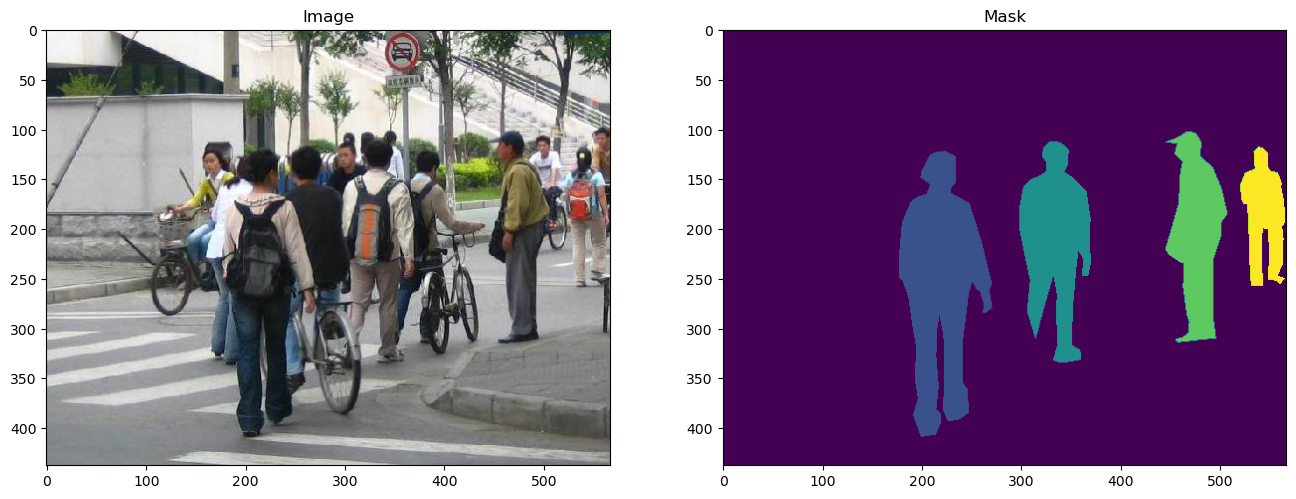

In [3]:
image = read_image("data/PennFudanPed/PNGImages/FudanPed00046.png")
mask = read_image("data/PennFudanPed/PedMasks/FudanPed00046_mask.png")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

In [4]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)

        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

## Define Model

### 1. Finetuning from pretrained model

In [5]:
# Load model pretrained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# Replace classifier with a new one, that has num_classes which is user-defined
num_classes = 2 # 1 class (person) + background

# Get number of input features for classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

### 2. Modifying the model to add a different backbone

In [6]:
# Load a pre-trained model for classification and return only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# "FasterRCNN" needs to know the number of output channels in a backbone. For mobilenet_v2, it is 1280, so add to it here
backbone.out_channels = 1280

# Make RPN generate 5x3 anchors per spatial location, with 5 different sizes and 3 different aspect ratios. Tuple[Tuple[int]] because 
# each feature map could potentially have different sizes and aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# Define what are the feature maps that will be used to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# If backbone returns a Tensor, featmap_names is expected to be [0]. More generally, backbone should return an "OrderedDict[Tensor]",
# and in "featmap_names" you can choose which feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=["0"],
    output_size=7,
    sampling_ratio=2
)

# Put the oieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

### Object detection and instance segmentation model for PennFudan Dataset

Finetune from a pre-trained model, given that the dataset is very small. So will follow approach number 1.

Here also want to compute the instance segmentation masks, so Mask R-CNN will be used.

In [7]:
def get_model_instance_segmentation(num_classes):
    # Load instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # Get number of input features for classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Now, get number of input features for mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    # Replace mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

## Putting everything together

In [8]:
# Download helper functions to simplify training and evaluating detection models
# !wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
# !wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
# !wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py
# !wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py
# !wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py

In [9]:
# Helper functions for data augmentation/transformation
def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())

    return T.Compose(transforms)

## Testing forward() method

In [10]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset(root="data/PennFudanPed", transforms=get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets) # Returns losses an detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x) # Returns predictions
print(predictions[0])

{'loss_classifier': tensor(0.0837, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0571, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0265, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0027, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [11]:
# Main function that performs training and validation

# Train on MPS or CPU, if MPS is not available (Apple)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Dataset has two classes only - background and person
num_classes = 2
# Use dataset and defined transformations
dataset = PennFudanDataset(root="data/PennFudanPed", transforms=get_transform(train=True))
dataset_test = PennFudanDataset(root="data/PennFudanPed", transforms=get_transform(train=False))

# Split dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# Define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

# Get model using helper function
model = get_model_instance_segmentation(num_classes=num_classes)
# move model to right device
model.to(device)

# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# LR scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# Number of training epochs
num_epochs = 2

for epoch in range(num_epochs):
    # Train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # Update learning rate
    lr_scheduler.step()
    # Evaluate on test dataset
    evaluate(model, data_loader_test, device)

print("DONE")

Epoch: [0]  [ 0/60]  eta: 0:09:48  lr: 0.000090  loss: 3.9822 (3.9822)  loss_classifier: 0.8524 (0.8524)  loss_box_reg: 0.2597 (0.2597)  loss_mask: 2.8586 (2.8586)  loss_objectness: 0.0092 (0.0092)  loss_rpn_box_reg: 0.0024 (0.0024)  time: 9.8132  data: 0.0179
Epoch: [0]  [10/60]  eta: 0:06:51  lr: 0.000936  loss: 1.6770 (2.2576)  loss_classifier: 0.4935 (0.5309)  loss_box_reg: 0.2597 (0.2830)  loss_mask: 0.7863 (1.4146)  loss_objectness: 0.0261 (0.0258)  loss_rpn_box_reg: 0.0037 (0.0033)  time: 8.2215  data: 0.0178
Epoch: [0]  [20/60]  eta: 0:05:09  lr: 0.001783  loss: 0.9369 (1.5306)  loss_classifier: 0.2407 (0.3607)  loss_box_reg: 0.2611 (0.2613)  loss_mask: 0.4778 (0.8824)  loss_objectness: 0.0240 (0.0212)  loss_rpn_box_reg: 0.0050 (0.0051)  time: 7.6260  data: 0.0176
Epoch: [0]  [30/60]  eta: 0:03:42  lr: 0.002629  loss: 0.5485 (1.2023)  loss_classifier: 0.1004 (0.2698)  loss_box_reg: 0.2294 (0.2425)  loss_mask: 0.2198 (0.6680)  loss_objectness: 0.0057 (0.0163)  loss_rpn_box_reg: 

/Users/damolaagbelese/Documents/github/AI-Mindspace/pytorch/image_video/engine.py:79: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025536809/work/aten/src/ATen/ParallelNative.cpp:228.)
  torch.set_num_threads(1)


creating index...
index created!
Test:  [ 0/50]  eta: 0:00:44  model_time: 0.8718 (0.8718)  evaluator_time: 0.0055 (0.0055)  time: 0.8835  data: 0.0061
Test:  [49/50]  eta: 0:00:00  model_time: 0.9089 (0.9823)  evaluator_time: 0.0024 (0.0037)  time: 0.9826  data: 0.0063
Test: Total time: 0:00:49 (0.9930 s / it)
Averaged stats: model_time: 0.9089 (0.9823)  evaluator_time: 0.0024 (0.0037)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.719
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.973
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.859
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.335
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.735
 Average R

## Predictions

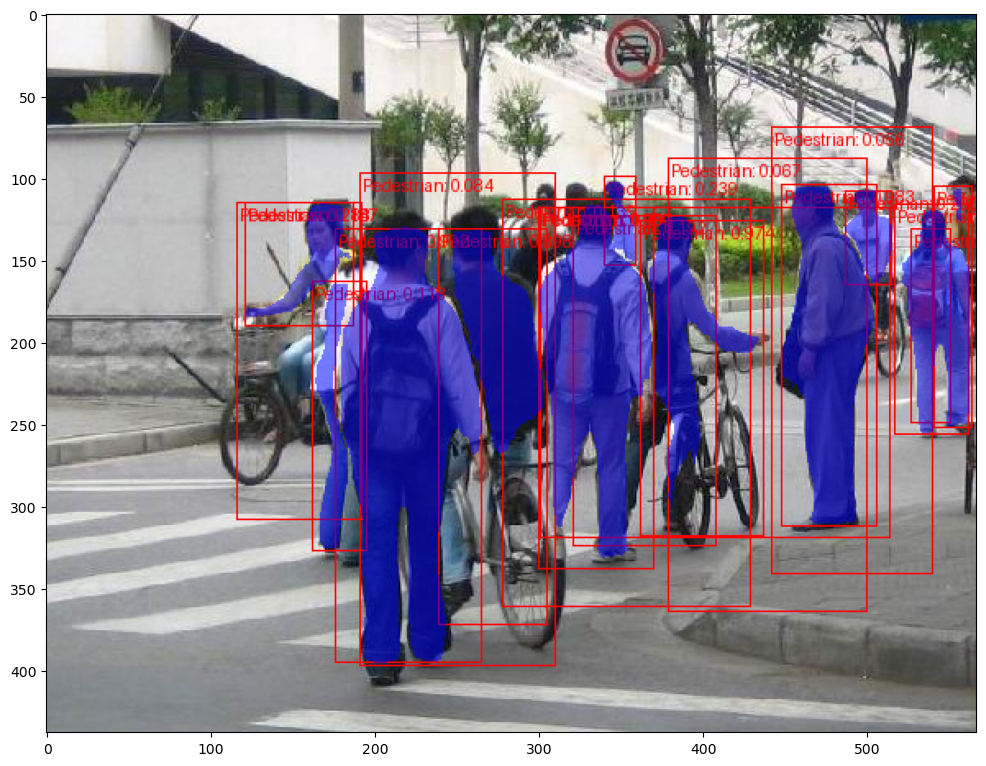

In [12]:
image = read_image("data/PennFudanPed/PNGImages/FudanPed00046.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # Convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"Pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))